# MyDramalist.com Recommender System  
Author: Hajid Lutfi Hidayanto  
Github: [LutfiHidayanto](https://github.com/LutfiHidayanto)

## Downloading Dataset

Link Dataset: [Kaggle](https://www.kaggle.com/datasets/amarang/mydramalist-ratings)

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d amarang/mydramalist-ratings


!unzip mydramalist-ratings

 96% 52.0M/53.9M [00:03<00:00, 24.7MB/s]
100% 53.9M/53.9M [00:04<00:00, 13.8MB/s]
Archive:  mydramalist-ratings.zip
  inflating: df_pairs.parquet        
  inflating: df_shows.parquet        
  inflating: df_users.parquet        


## Importing Library

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics.pairwise import cosine_similarity

## Exploratory Data Analysis & Data Preprocessing

In [ ]:
pairs = pd.read_parquet('/content/df_pairs.parquet')
shows = pd.read_parquet('/content/df_shows.parquet')
users = pd.read_parquet('/content/df_users.parquet')

In [ ]:
print(f"Jumlah data pairs: {len(pairs)}")
print(f"Jumlah data shows: {len(shows)}")
print(f"Jumlah data users: {len(users)}")

Jumlah data pairs: 14108062
Jumlah data shows: 50411
Jumlah data users: 84607


### shows

In [ ]:
shows.head()

,country,year,kind,title,sid
0,South Korea,2019,Drama,Melting Me Softly,25652
1,South Korea,2021,Drama,Snowdrop,33603
2,South Korea,2020,Drama,365: Repeat the Year,29824
3,South Korea,2019,Drama,Big Issue,24045
4,South Korea,2019,Drama,Graceful Family,25688


In [ ]:
shows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50411 entries, 0 to 50410
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   country  50411 non-null  category
 1   year     50411 non-null  int64   
 2   kind     50411 non-null  category
 3   title    50411 non-null  category
 4   sid      50411 non-null  int64   
dtypes: category(3), int64(2)
memory usage: 2.4 MB


Terdapat 3 data kategorikal (country, kind, title) dan 2 data numerik (year, sid)

In [ ]:
shows.isnull().sum()

country    0
year       0
kind       0
title      0
sid        0
dtype: int64

Tidak ada data null dalam shows

In [ ]:
pd.unique(shows['kind'].to_list())

array(['Drama', 'Movie', 'Drama Special', 'TV Show'], dtype=object)

In [ ]:

duplicates_mask = shows['sid'].duplicated()
sid_with_duplicates = shows['sid'][duplicates_mask]

print(sid_with_duplicates)
print(f"Banyak duplicates: {len(sid_with_duplicates)}")

16152    18636
16166    39529
28975     4296
29217    47785
31065    20302
32384    30984
32385    33354
39478    25263
39719    49937
40359    22425
40757    33428
40890    40469
42120    44079
45996     2188
47926    24466
49038    32310
49127    25259
50340    24853
Name: sid, dtype: int64
Banyak duplicates: 18


In [ ]:
duplicated_entries = shows[shows['sid'].isin(sid_with_duplicates)].sort_values(by='sid')
print(len(duplicated_entries))
duplicated_entries

36


,country,year,kind,title,sid
45996,South Korea,2011,Movie,A Reason to Live,2188
18087,South Korea,2011,Movie,A Reason To Live,2188
4437,China,2014,Drama,Scarlet Heart 2,4296
28975,China,2014,Drama,Scarlet Heart Season 2,4296
3646,South Korea,2020,Movie,Are We In Love?,18636
16152,South Korea,2020,Movie,Are We in Love?,18636
7684,Japan,2018,Movie,Love At Least,20302
31065,Japan,2018,Movie,Love at Least,20302
40359,Thailand,2018,Drama Special,"Club Friday Season 10: Him, Her, and Another",22425
22576,Thailand,2018,Drama,"Club Friday Season 10: Him, Her, and Another",22425


Mengecek di situs mydramalist.com untuk menentukan data yang benar

In [ ]:
shows = shows.drop(index=[18087, 4437, 16152, 31065, 22576, 13059, 37990, 29451, 29450, 13061, 49038, 13062, 18249, 13071, 17114, 34194, 8698, 39719])

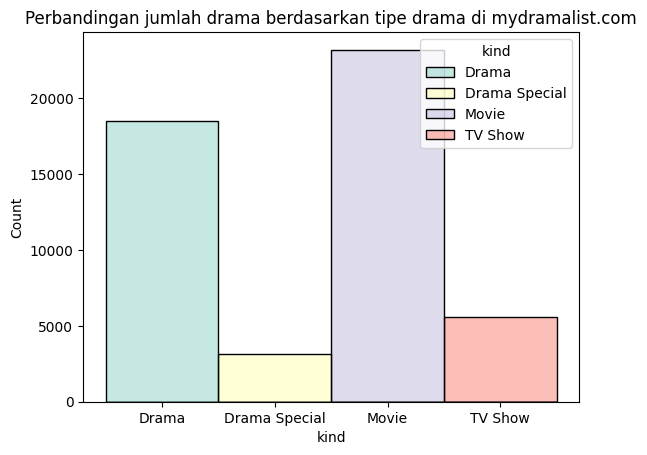

In [ ]:
sns.histplot(x='kind', data=shows, palette="Set3", hue="kind")
plt.title("Perbandingan jumlah drama berdasarkan tipe drama di mydramalist.com")
plt.show()

In [ ]:
shows[shows['kind'] == 'TV Show']

,country,year,kind,title,sid
312,South Korea,2018,TV Show,Busted Season 1,19102
313,South Korea,2019,TV Show,Busted Season 2,21895
314,South Korea,2021,TV Show,Busted Season 3,31208
504,China,2020,TV Show,Produce Camp 2020,30075
505,China,2021,TV Show,Produce Camp 2021,34560
...,...,...,...,...,...
50404,South Korea,2020,TV Show,Dakcument,35769
50405,South Korea,2022,TV Show,Crush's BlackVox,49082
50406,South Korea,2021,TV Show,DKB vlog,45326
50407,South Korea,2019,TV Show,"Go Together, Travel Alone",34806


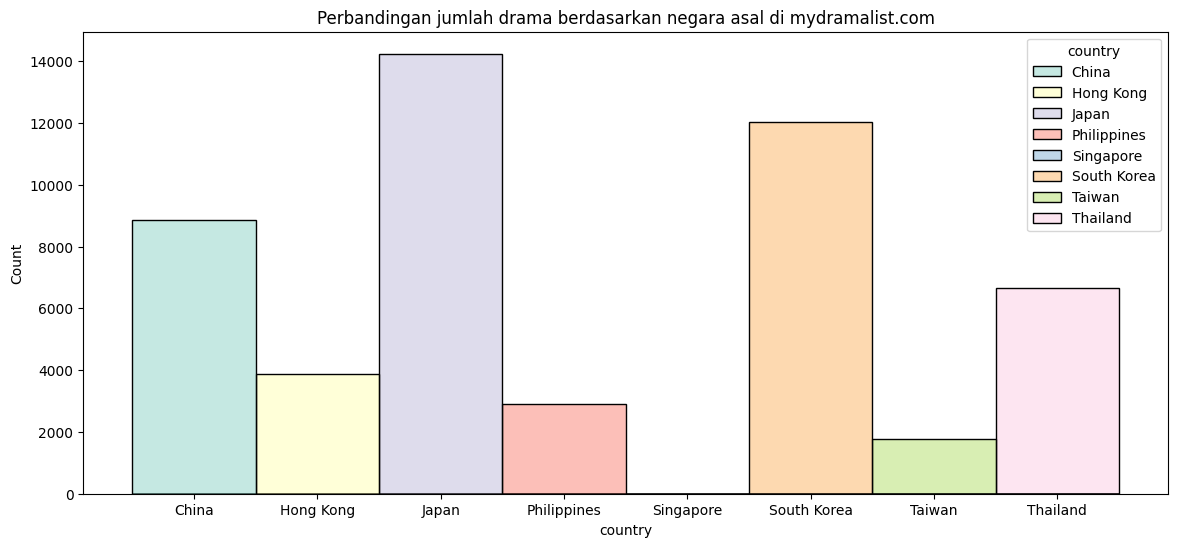

In [ ]:
plt.figure(figsize=(14, 6))
sns.histplot(x='country', data=shows, palette="Set3", hue="country")
plt.title("Perbandingan jumlah drama berdasarkan negara asal di mydramalist.com")
plt.show()

Melihat shows dari singapore

In [ ]:
shows[shows['country'] == 'Singapore']

,country,year,kind,title,sid
28606,Singapore,2018,Movie,The Big Day,22788


In [ ]:
duplicates_mask = shows['sid'].duplicated()
sid_with_duplicates = shows['sid'][duplicates_mask]

print(sid_with_duplicates)
print(f"Banyak duplicates: {len(sid_with_duplicates)}")

Series([], Name: sid, dtype: int64)
Banyak duplicates: 0


In [ ]:
shows['kind country'] = shows['kind'].astype(str) + " " + shows['country'].astype(str)
shows.head()

,country,year,kind,title,sid,kind country
0,South Korea,2019,Drama,Melting Me Softly,25652,Drama South Korea
1,South Korea,2021,Drama,Snowdrop,33603,Drama South Korea
2,South Korea,2020,Drama,365: Repeat the Year,29824,Drama South Korea
3,South Korea,2019,Drama,Big Issue,24045,Drama South Korea
4,South Korea,2019,Drama,Graceful Family,25688,Drama South Korea


## users

In [ ]:
users.head()

,username,gender,join_date,last_online,ndropped,ncompleted,uid
0,honestlybananas,F,2019-10-15,2022-05-15,2,6,61239
1,palmawurzel,U,2021-07-24,2023-02-24,18,164,73580
2,pulomeow,F,2022-05-09,2022-05-30,27,69,74723
3,7756207,F,2020-01-16,2023-04-10,35,383,6389
4,Cariad,F,2012-01-03,2014-07-27,9,354,21209


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84607 entries, 0 to 84606
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   username     84607 non-null  object        
 1   gender       84607 non-null  category      
 2   join_date    84029 non-null  datetime64[ns]
 3   last_online  84028 non-null  datetime64[ns]
 4   ndropped     84607 non-null  int64         
 5   ncompleted   84607 non-null  int64         
 6   uid          84607 non-null  int64         
dtypes: category(1), datetime64[ns](2), int64(3), object(1)
memory usage: 4.0+ MB


In [ ]:
users.isnull().sum()

username         0
gender           0
join_date      578
last_online    579
ndropped         0
ncompleted       0
uid              0
dtype: int64

Terdapat null di dalam dataset tetapi tidak masalah karena fitur-fitur yang memiliki null tidak digunakan (join_date, last_online)

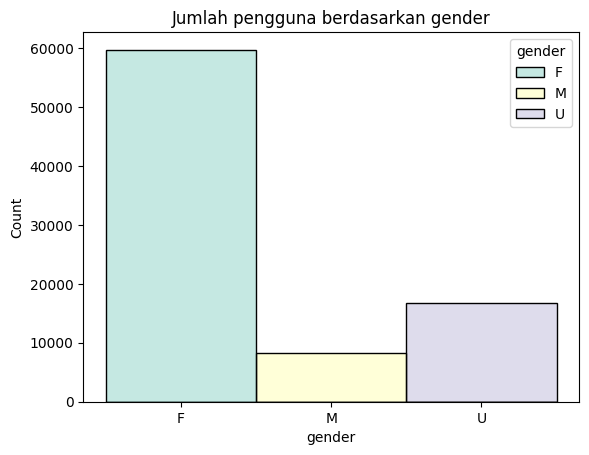

In [ ]:
sns.histplot(x='gender', data=users, palette="Set3", hue="gender")
plt.title("Jumlah pengguna berdasarkan gender")
plt.show()

Distribusi gender users:  
F: Female  
M: Male  
U: Unknown (tidak memilih gender)

In [ ]:
duplicates_mask = users['uid'].duplicated()
uid_with_duplicates = users['uid'][duplicates_mask]

print(uid_with_duplicates)
print(f"Banyak duplicates: {len(uid_with_duplicates)}")

Series([], Name: uid, dtype: int64)
Banyak duplicates: 0


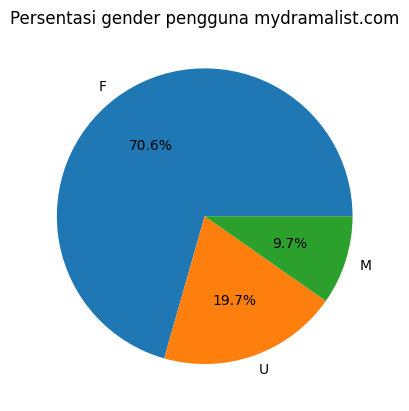

In [ ]:
gender_counts = users['gender'].value_counts()

plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%")
plt.title("Persentasi gender pengguna mydramalist.com")
plt.show()

Tidak ada data duplikat pada users

### pairs/rating

In [ ]:
pairs.head()

,score,sid,uid,ep_seen,ep_total,completed
0,7.0,25652,61239,4,16,False
1,1.5,33603,61239,0,16,False
2,9.0,29824,61239,24,24,True
3,7.5,24045,61239,32,32,True
4,10.0,25688,61239,16,16,True


In [ ]:
pairs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14108062 entries, 0 to 14108061
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   score      float64
 1   sid        int64  
 2   uid        int64  
 3   ep_seen    int64  
 4   ep_total   int64  
 5   completed  bool   
dtypes: bool(1), float64(1), int64(4)
memory usage: 551.6 MB


Terdapat 5 data numerik (score, sid, uid, ep_seen, ep_total) dan 1 kategorikal (completed)

In [ ]:
pairs.isnull().sum()

score        0
sid          0
uid          0
ep_seen      0
ep_total     0
completed    0
dtype: int64

Tidak terdapat null dalam dataset

In [ ]:
pairs.describe()

,score,sid,uid,ep_seen,ep_total
count,1.410806e+07,1.410806e+07,1.410806e+07,1.410806e+07,1.410806e+07
mean,6.282575e+00,1.925393e+04,4.259047e+04,1.383926e+01,1.513486e+01
std,3.563448e+00,1.335742e+04,2.418120e+04,1.986707e+01,2.362473e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00
25%,5.000000e+00,8.632000e+03,2.181400e+04,2.000000e+00,6.000000e+00
50%,7.500000e+00,1.728400e+04,4.259800e+04,1.200000e+01,1.500000e+01
75%,9.000000e+00,2.961500e+04,6.349400e+04,1.600000e+01,2.000000e+01
max,1.000000e+01,5.039200e+04,8.460600e+04,1.183000e+04,1.183000e+04


Rating minimum = 0  
Rating maximum = 10  
Mean Rating = 6.282575

Banyak data setelah dipreprocess:

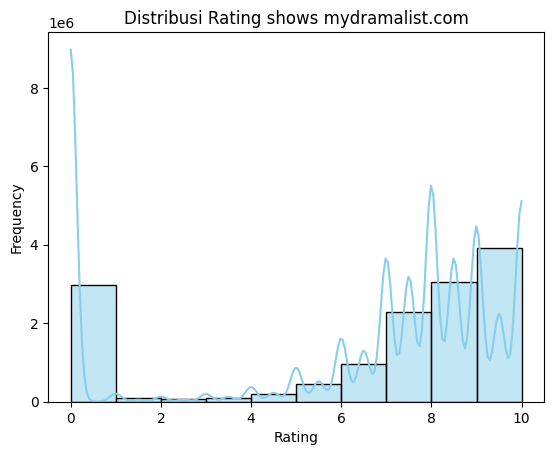

In [ ]:
sns.histplot(pairs['score'], bins=10, kde=True, color='skyblue', edgecolor='black')

plt.title('Distribusi Rating shows mydramalist.com')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

Rating banyak terdistribusi pada rating 7-10 dan 0.

Banyak data setelah dipreprocess

In [ ]:
print(f"banyak data pairs {len(pairs)}")
print(f"banyak data shows {len(shows)}")
print(f"banyak data users {len(users)}")

banyak data pairs 14108062
banyak data shows 50393
banyak data users 84607


## Content-Based FIltering

### Data Preprocessing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer()

data = shows.loc[:10000, 'kind country']
tf.fit(data)

tf.get_feature_names_out()

array(['china', 'drama', 'hong', 'japan', 'kong', 'korea', 'movie',
       'philippines', 'show', 'south', 'special', 'taiwan', 'thailand',
       'tv'], dtype=object)

In [ ]:
tfidf_matrix = tf.fit_transform(data)

tfidf_matrix.shape

(9999, 14)

In [ ]:
tfidf_matrix.todense()

matrix([[0.        , 0.43122432, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.43122432, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.43122432, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.88827143, 0.45931892, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.2495064 , 0.68474322, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.2495064 , 0.68474322, ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=shows.loc[:10000, 'title']
).sample(8)

,china,drama,hong,japan,kong,korea,movie,philippines,show,south,special,taiwan,thailand,tv
title,,,,,,,,,,,,,,
The Promised Neverland,0.000000,0.000000,0.0,0.712431,0.0,0.000000,0.701743,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Kamen Rider Black Sun,0.000000,0.535427,0.0,0.844581,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Cry Me A River of Stars,0.888271,0.459319,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Banana Actually,0.000000,0.431224,0.0,0.000000,0.0,0.637983,0.000000,0.0,0.0,0.637983,0.0,0.0,0.0,0.0
The World of Fantasy,0.888271,0.459319,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Mischievous Kiss The Movie: High School,0.000000,0.000000,0.0,0.712431,0.0,0.000000,0.701743,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
The Lure of the Hua Xu Song,0.888271,0.459319,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
Fake Phoenixes,0.888271,0.459319,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [ ]:
sparse_tfidf_matrix = csr_matrix(tfidf_matrix)

Digunakan sparse matrix agar ram tidak overflow

### Cosine Similarity

In [ ]:

cosine_sim = cosine_similarity(sparse_tfidf_matrix)
cosine_sim

array([[1.        , 1.        , 1.        , ..., 0.19806949, 0.10759323,
        0.10759323],
       [1.        , 1.        , 1.        , ..., 0.19806949, 0.10759323,
        0.10759323],
       [1.        , 1.        , 1.        , ..., 0.19806949, 0.10759323,
        0.10759323],
       ...,
       [0.19806949, 0.19806949, 0.19806949, ..., 1.        , 0.11460301,
        0.11460301],
       [0.10759323, 0.10759323, 0.10759323, ..., 0.11460301, 1.        ,
        1.        ],
       [0.10759323, 0.10759323, 0.10759323, ..., 0.11460301, 1.        ,
        1.        ]])

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=shows.loc[:10000, 'title'], columns=shows.loc[:10000, 'title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9999, 9999)


title,Fly With The Gold,The Secret Life of My Secretary,Gonin Saga,Soul Mate,Boy Meets Boy
title,,,,,
A Shoulder to Cry On,0.000000,1.000000,0.000000,0.000000,0.724360
My Amazing Boyfriend,0.000000,0.198069,0.000000,0.692465,0.000000
Perfect Wedding,0.000000,0.198069,0.000000,0.692465,0.000000
Under the Canopy of Love,0.000000,0.107593,0.000000,0.000000,0.000000
Magic Star,0.000000,0.198069,0.000000,0.692465,0.000000
Yellow,0.000000,1.000000,0.000000,0.000000,0.724360
Camp Sawi,0.289800,0.000000,0.289800,0.258653,0.246210
Romance Zero,0.000000,1.000000,0.000000,0.000000,0.724360
Homestay,0.391827,0.000000,0.391827,0.349715,0.332891


### Top N recommendations

In [ ]:
def shows_recommendations(nama_shows, similarity_data=cosine_sim_df, items=shows.loc[:10000, ['title', 'kind country']], k=5):

    index = similarity_data.loc[:,nama_shows].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(nama_shows, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
shows_recommendations('Melting Me Softly')

,title,kind country
0,Missing Noir M,Drama South Korea
1,Boarding House #24,Drama South Korea
2,Between Friendship and Love,Drama South Korea
3,Birdie Buddy,Drama South Korea
4,Big Man,Drama South Korea


## Collaborative Filtering

### Data Preprocessing

In [ ]:
df = pairs

In [ ]:
user_ids = df["uid"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["sid"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["uid"].map(user2user_encoded)
df["shows"] = df["sid"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["score"] = df["score"].values.astype(np.float32)

min_rating = min(df["score"])
max_rating = max(df["score"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 80189, Number of Movies: 50393, Min rating: 0.0, Max rating: 10.0


In [ ]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "shows"]].values
y = df["score"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### Building RecommenderNet

In [ ]:
class RecommenderNet(tf.keras.Model):

  def __init__(self, num_users, num_shows, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_shows = num_shows
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( 
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) 
    self.show_embedding = layers.Embedding( 
        num_shows,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.show_bias = layers.Embedding(num_shows, 1) 

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) 
    user_bias = self.user_bias(inputs[:, 0]) 
    show_vector = self.show_embedding(inputs[:, 1]) 
    show_bias = self.show_bias(inputs[:, 1]) 

    dot_user_show = tf.tensordot(user_vector, show_vector, 2)

    x = dot_user_show + user_bias + show_bias

    return tf.nn.sigmoid(x) 

In [ ]:
model = RecommenderNet(num_users, num_movies, 200) 

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
target_rmse = 0.27

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('root_mean_squared_error') < target_rmse and logs.get('val_root_mean_squared_error') < target_rmse):
      print(f"\RMSE telah mencapai < {target_rmse}!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 512,
    epochs = 10,
    validation_data = (x_val, y_val),
    callbacks=[callbacks]
)

Epoch 1/10
24800/24800 [==============================] - 399s 16ms/step - loss: 0.6367 - root_mean_squared_error: 0.3399 - val_loss: 0.6162 - val_root_mean_squared_error: 0.3247
Epoch 2/10
24800/24800 [==============================] - 389s 16ms/step - loss: 0.6014 - root_mean_squared_error: 0.3134 - val_loss: 0.5886 - val_root_mean_squared_error: 0.3032
Epoch 3/10
24800/24800 [==============================] - 374s 15ms/step - loss: 0.5782 - root_mean_squared_error: 0.2951 - val_loss: 0.5694 - val_root_mean_squared_error: 0.2878
Epoch 4/10
24800/24800 [==============================] - 360s 15ms/step - loss: 0.5621 - root_mean_squared_error: 0.2820 - val_loss: 0.5560 - val_root_mean_squared_error: 0.2768
Epoch 5/10
24800/24800 [==============================] - 370s 15ms/step - loss: 0.5506 - root_mean_squared_error: 0.2726 - val_loss: 0.5460 - val_root_mean_squared_error: 0.2686
Epoch 6/10
24800/24800 [==============================] - 369s 15ms/step - loss: 0.5426 - root_mean_squar

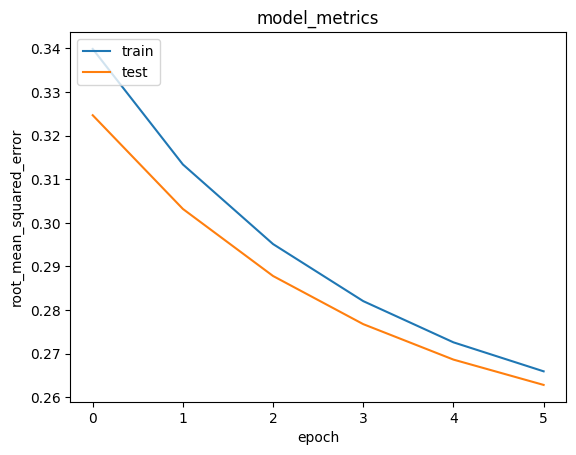

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Top N Recommendations

In [ ]:
user_id = df['uid'].sample(1).iloc[0]
shows_visited_by_user = df[df['uid'] == user_id]

shows_not_visited = shows[~shows['sid'].isin(shows_visited_by_user['sid'].values)]['sid']
shows_not_visited = list(
    set(shows_not_visited)
    .intersection(set(movie2movie_encoded.keys()))
)

shows_not_visited = [[movie2movie_encoded.get(x)] for x in shows_not_visited]
user_encoder = user2user_encoded.get(user_id)
user_shows_array = np.hstack(
    ([[user_encoder]] * len(shows_not_visited), shows_not_visited)
)

In [ ]:
ratings = model.predict(user_shows_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_shows_ids = [
    movie2movie_encoded.get(shows_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('shows with high ratings from user')
print('----' * 8)

top_shows_user = (
    shows_visited_by_user.sort_values(
        by = 'score',
        ascending=False
    )
    .head(5)
    ['sid'].values
)

shows_df_rows = shows[shows['sid'].isin(top_shows_user)]
print(shows_df_rows[['title', 'kind']])

print('----' * 8)
print('Top 10 shows recommendation')
print('----' * 8)

recommended_shows = shows[shows['sid'].isin(recommended_shows_ids)]
print(recommended_shows[['title', 'kind']])

1530/1530 [==============================] - 3s 2ms/step
Showing recommendations for users: 5052
shows with high ratings from user
--------------------------------
                         title   kind
97              Move to Heaven  Drama
132                   Stranger  Drama
432                 Love Alarm  Drama
2004  Misaeng: Incomplete Life  Drama
4929     Like Father, Like Son  Movie
--------------------------------
Top 10 shows recommendation
--------------------------------
                              title   kind
2821                     Departures  Movie
8631                White Vengeance  Movie
9502              A Handful of Love  Drama
10545       My Sister, The Pig Lady  Movie
14683            The Breaking Point  Drama
16414           4 Shimai Tantei Dan  Drama
22168  The File of Justice Season 5  Drama
22368                    Viva! Love  Movie
34191                   Cupid Above  Drama
48969              Hooligan Sparrow  Movie
